In [32]:
import mediapipe as mp
from mediapipe.python.solutions.pose import PoseLandmark
from pprint import pprint
from PIL import Image
import pandas as pd
from mediapipe.tasks import python as mpy
from mediapipe.tasks.python import vision
from pathlib import Path
import numpy as np
import cv2
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import matplotlib.pyplot as plt
import torch

In [33]:
# print(PoseLandmark.__dict__)
members = PoseLandmark._member_names_

In [34]:
# download one from here:
# https://ai.google.dev/edge/mediapipe/solutions/vision/pose_landmarker/index#models
model_path = "/Users/sidsurakanti/projects/what-punch/pose_landmarker_full.task"
# model_path = "/"

BaseOptions = mp.tasks.BaseOptions
PoseLandmarker = vision.PoseLandmarker
PoseLandmarkerOptions = vision.PoseLandmarkerOptions
running_mode = vision.RunningMode.IMAGE 
load_mp_img = mp.Image.create_from_file 

options = PoseLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=running_mode
)
detector = PoseLandmarker.create_from_options(options)

I0000 00:00:1750471813.341174   34829 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3
W0000 00:00:1750471813.429662   43947 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1750471813.438802   43949 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [35]:
def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())

  return annotated_image

In [36]:
class FakeLandmark:
    def __init__(self, x=0.0, y=0.0, z=0.0, visibility=0.0):
        self.x = x
        self.y = y
        self.z = z
        self.visibility = visibility

def get_landmarks(punch):
    results = []
    folder = Path.cwd() / "assets" / punch
    # folder = Path("assets/test")
    
    for file in sorted(list(folder.glob("*.png"))):
        # print(folder)
        # img = Image.open(str(file))
        img = load_mp_img(str(file))
        # pprint(type(img).numpy_view.__doc__)
        # # pprint(type(img).__doc__)
        # print(img)

        landmarks = detector.detect(img)
        print(landmarks)
        marks = landmarks.pose_landmarks[0] if landmarks.pose_landmarks else FakeLandmark()
        results.append(marks)
    
        # pprint(type(marks[1]).__dict__)
    
        # print(img.numpy_view().shape)
        # alpha_stripped = img.numpy_view()[..., :3]
        # bgr_img = cv2.cvtColor(alpha_stripped, cv2.COLOR_RGB2BGR)
        # annotated_image = draw_landmarks_on_image(bgr_img, landmarks)
    
        # cv2.imshow("preview", annotated_image)
        # key = cv2.waitKey(0)  # waits for key press
        # if key == ord('q'): break
        # cv2.destroyAllWindows()  # closes the window
    return results

In [37]:
def marks_to_data(marks) -> tuple:
    data = []
    for res in marks:
        data.append([[lm.x, lm.y, lm.z, lm.visibility] for idx, (name, lm) in enumerate(zip(PoseLandmark._member_names_, res))])
    
    data = np.array(data)
    idxs = pd.MultiIndex.from_product([np.arange(data.shape[0]), np.arange(len(members))], names=["example", "landmark"])
    df = pd.DataFrame(data.reshape(-1, 4), index=idxs, columns=["x", "y", "z", "visibility"])
    return (data, df)

In [38]:
punches = [ "jab", "straight",  "uppercut", "hook"] # "idle",
data = []

for punch in punches:
    marks = get_landmarks(punch)
    data.append(marks_to_data(marks))
T


PoseLandmarkerResult(pose_landmarks=[[NormalizedLandmark(x=0.5957639813423157, y=0.31699708104133606, z=-0.2880232036113739, visibility=0.9999717473983765, presence=0.9996761083602905), NormalizedLandmark(x=0.6126950979232788, y=0.2995795011520386, z=-0.24526360630989075, visibility=0.9999668598175049, presence=0.9989521503448486), NormalizedLandmark(x=0.6223276853561401, y=0.3001292943954468, z=-0.2453509271144867, visibility=0.9999549388885498, presence=0.9989843964576721), NormalizedLandmark(x=0.6308912634849548, y=0.30080708861351013, z=-0.2456347495317459, visibility=0.999956488609314, presence=0.9989414811134338), NormalizedLandmark(x=0.5792567133903503, y=0.2969517409801483, z=-0.27479830384254456, visibility=0.9999645948410034, presence=0.9989192485809326), NormalizedLandmark(x=0.565319836139679, y=0.29587486386299133, z=-0.274874746799469, visibility=0.9999527931213379, presence=0.9988333582878113), NormalizedLandmark(x=0.5501673221588135, y=0.29518863558769226, z=-0.275046944

TypeError: 'FakeLandmark' object is not iterable

In [ ]:
# df.loc[(0, 0): (7, 32)]
pd.set_option('display.max_rows', None)

In [ ]:
# df.describe()

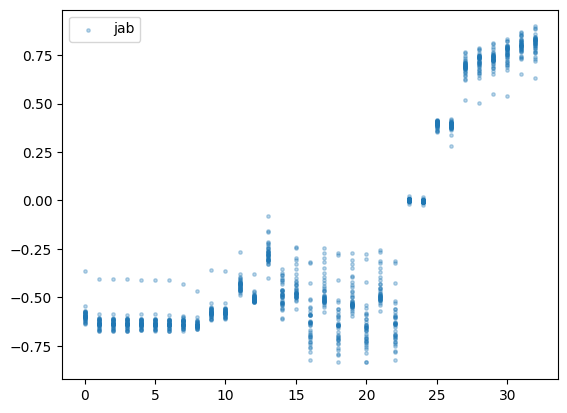

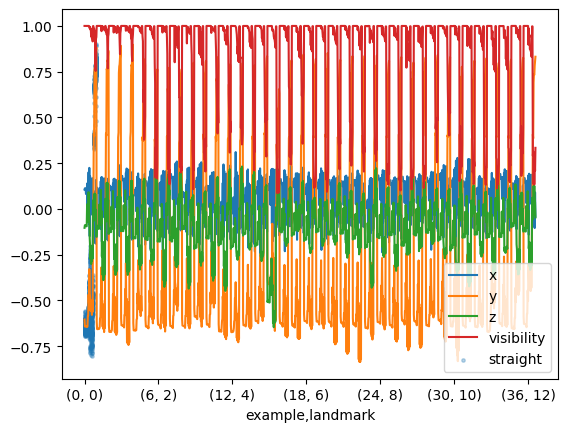

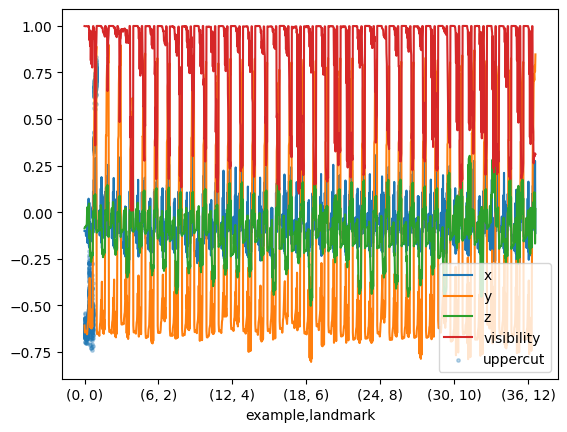

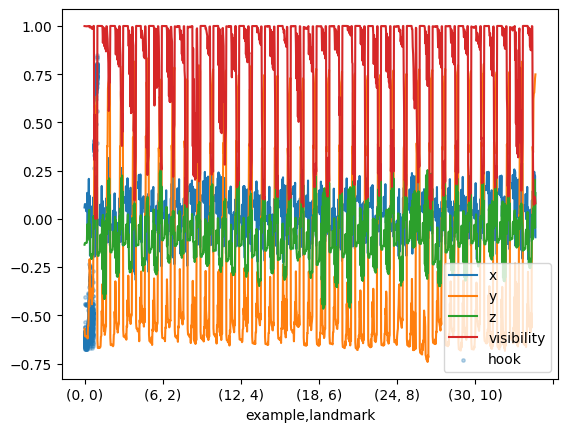

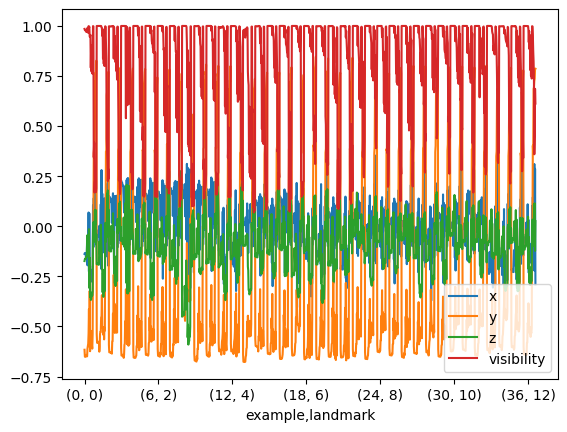

In [ ]:
for punch, (arr, df) in zip(punches, data):
    # df = df.loc[df.index.get_level_values(1).isin(list(range(13, 23)))] 
    plt.scatter([x for x in df.index.get_level_values(1)], df['y'], label=punch, alpha=0.3, s=6)
    plt.legend()
    df.plot()

In [ ]:
# np.std(data, axis=0)[:, :3]

In [ ]:
list(enumerate(members))

[(0, 'NOSE'),
 (1, 'LEFT_EYE_INNER'),
 (2, 'LEFT_EYE'),
 (3, 'LEFT_EYE_OUTER'),
 (4, 'RIGHT_EYE_INNER'),
 (5, 'RIGHT_EYE'),
 (6, 'RIGHT_EYE_OUTER'),
 (7, 'LEFT_EAR'),
 (8, 'RIGHT_EAR'),
 (9, 'MOUTH_LEFT'),
 (10, 'MOUTH_RIGHT'),
 (11, 'LEFT_SHOULDER'),
 (12, 'RIGHT_SHOULDER'),
 (13, 'LEFT_ELBOW'),
 (14, 'RIGHT_ELBOW'),
 (15, 'LEFT_WRIST'),
 (16, 'RIGHT_WRIST'),
 (17, 'LEFT_PINKY'),
 (18, 'RIGHT_PINKY'),
 (19, 'LEFT_INDEX'),
 (20, 'RIGHT_INDEX'),
 (21, 'LEFT_THUMB'),
 (22, 'RIGHT_THUMB'),
 (23, 'LEFT_HIP'),
 (24, 'RIGHT_HIP'),
 (25, 'LEFT_KNEE'),
 (26, 'RIGHT_KNEE'),
 (27, 'LEFT_ANKLE'),
 (28, 'RIGHT_ANKLE'),
 (29, 'LEFT_HEEL'),
 (30, 'RIGHT_HEEL'),
 (31, 'LEFT_FOOT_INDEX'),
 (32, 'RIGHT_FOOT_INDEX')]

In [ ]:
X = []
y = []

for punch, (arr, df) in zip(punches, data):
  X.append(arr)
  y += [punches.index(punch)] * arr.shape[0]
X = np.concatenate(X) 
y = np.array(y) 

In [ ]:
X.shape

(146, 33, 4)

In [ ]:
np.unique(y, return_counts=1)

(array([0, 1, 2, 3]), array([37, 37, 35, 37]))

In [ ]:
# torch.save((X, y), "data.pkl")